# 2. Overfitting & Validation

This notebook covers overfitting, underfitting, and cross-validation techniques for model evaluation.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Load ABIDE data
data = pd.read_csv('./data/abide2.tsv', sep='\t')
X_all = data.filter(like='fs')
y = data['age']

## Overfitting vs. Underfitting

**Overfitting**: Model fits training data too closely, capturing noise instead of signal
- High training performance, poor test performance
- Model is too flexible/complex

**Underfitting**: Model is too simple to capture patterns
- Poor training and test performance
- Model lacks flexibility

### Toy Example: Polynomial Regression

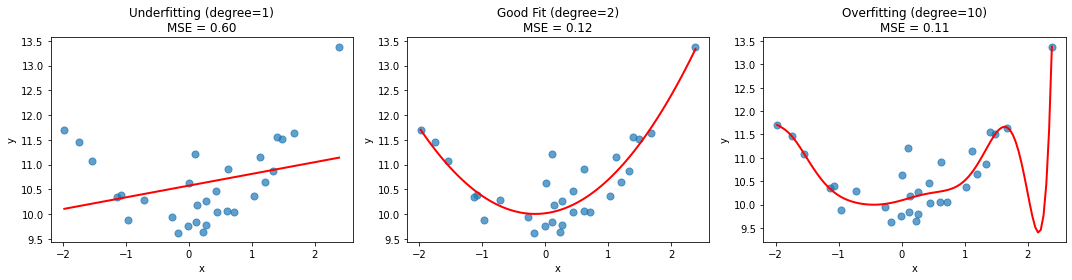

In [2]:
# Generate synthetic data with quadratic relationship
np.random.seed(10)
x = np.random.normal(size=30)
y_syn = (0.7 * x) ** 2 + 0.1 * x + np.random.normal(10, 0.5, size=30)

# Helper function to create polynomial pipelines
def make_pipeline(degree=1):
    return Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=degree, include_bias=False)),
        ("linear_regression", LinearRegression())
    ])

# Fit models with different polynomial degrees
degrees = [1, 2, 10]
x_range = np.linspace(x.min(), x.max(), 100)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
titles = ['Underfitting (degree=1)', 'Good Fit (degree=2)', 'Overfitting (degree=10)']

for ax, degree, title in zip(axes, degrees, titles):
    model = make_pipeline(degree)
    model.fit(x[:, None], y_syn)
    
    y_fit = model.predict(x_range[:, None])
    mse = mean_squared_error(y_syn, model.predict(x[:, None]))
    
    ax.scatter(x, y_syn, s=50, alpha=0.7)
    ax.plot(x_range, y_fit, 'r-', lw=2)
    ax.set_title(f"{title}\nMSE = {mse:.2f}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()

**Key insight**: The 10th-degree polynomial has the lowest training error but clearly overfits!

## Cross-Validation: Train/Test Split

To detect overfitting, we must evaluate on **independent test data**.

In [3]:
from sklearn.model_selection import train_test_split

# Split data: 50% train, 50% test
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, train_size=0.5, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 502
Test set size: 502


In [4]:
# Fit model using ALL features (will overfit!)
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate on both train and test sets
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)

print(f"R² on training set: {r2_train:.3f}")
print(f"R² on test set: {r2_test:.3f}")
print(f"\n⚠️ Difference: {r2_train - r2_test:.3f} indicates severe overfitting!")

R² on training set: 1.000
R² on test set: -0.871

⚠️ Difference: 1.871 indicates severe overfitting!


### Solution: Use Fewer Features

In [5]:
# Sample only 200 features
X_small = X_all.sample(200, axis='columns', random_state=99)
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y, train_size=0.5, random_state=99
)

model.fit(X_train, y_train)

r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)

print(f"R² on training set: {r2_train:.3f}")
print(f"R² on test set: {r2_test:.3f}")
print(f"\n✓ Much better! Model generalizes to new data.")

R² on training set: 0.792
R² on test set: 0.458

✓ Much better! Model generalizes to new data.


## K-Fold Cross-Validation

Problem with train/test split: wastes data (only 50% used for training).

**Solution**: K-fold cross-validation
1. Split data into K folds
2. For each fold: train on K-1 folds, test on remaining fold
3. Average performance across all K folds

Benefits:
- Uses all data for both training and testing
- More stable performance estimates
- Reduces variance in evaluation

In [6]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation
K = 5
model = LinearRegression()

# cross_val_score returns array of scores (one per fold)
cv_scores = cross_val_score(model, X_small, y, cv=K, scoring='r2')

print("Individual fold scores:", cv_scores.round(3))
print(f"\nMean cross-validated R²: {cv_scores.mean():.3f}")
print(f"Standard deviation: {cv_scores.std():.3f}")

Individual fold scores: [0.604 0.538 0.568 0.568 0.557]

Mean cross-validated R²: 0.567
Standard deviation: 0.021


## Learning Curves

Visualize model performance as a function of training set size to diagnose overfitting/underfitting.

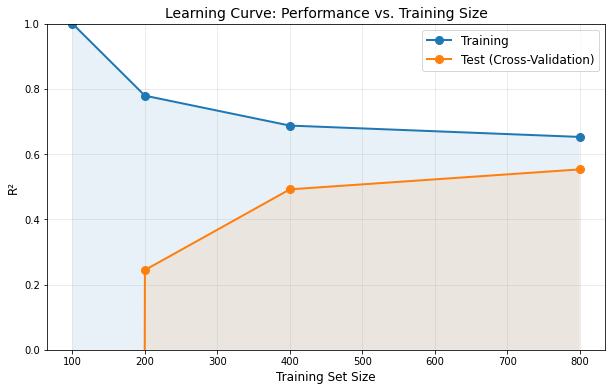

Interpretation:
- Large gap between train/test curves = overfitting
- Test curve improves with more data = model benefits from larger samples
- Curves haven't converged = could benefit from even more data


In [6]:
from sklearn.model_selection import learning_curve

# Sample 100 features
X = X_all.sample(100, axis=1, random_state=100)

# Training sizes to evaluate
train_sizes = [100, 200, 400, 800]

# Compute learning curve
sizes, train_scores, test_scores = learning_curve(
    LinearRegression(), X, y, 
    train_sizes=train_sizes, 
    cv=5, 
    shuffle=True,
    scoring='r2'
)

# Calculate means
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sizes, train_mean, 'o-', label='Training', linewidth=2, markersize=8)
plt.plot(sizes, test_mean, 'o-', label='Test (Cross-Validation)', linewidth=2, markersize=8)
plt.fill_between(sizes, 0, train_mean, alpha=0.1)
plt.fill_between(sizes, 0, test_mean, alpha=0.1)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.title('Learning Curve: Performance vs. Training Size', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()

print("Interpretation:")
print("- Large gap between train/test curves = overfitting")
print("- Test curve improves with more data = model benefits from larger samples")
print("- Curves haven't converged = could benefit from even more data")

**Key Observations:**

1. **More features ≠ always better**: 
   - With small samples (n=100), the 5-feature model outperforms the 100-feature model!
   - The 100-feature model severely overfits with limited data

2. **Sample size matters**:
   - The 100-feature model needs ~800 samples to match the 5-feature model
   - More complex models require more data to avoid overfitting

3. **The curse of dimensionality**:
   - With 100 features and 100 samples, training R² ≈ 1.0 (perfect fit)
   - But test R² ≈ 0.0 (useless predictions)
   - The model memorizes training noise instead of learning patterns

**Practical Lesson**: Match model complexity to your dataset size. With limited data, simpler models often generalize better!

Helper function defined: plot_learning_curves()
Comparing model complexity across different training sizes...
This may take a minute...



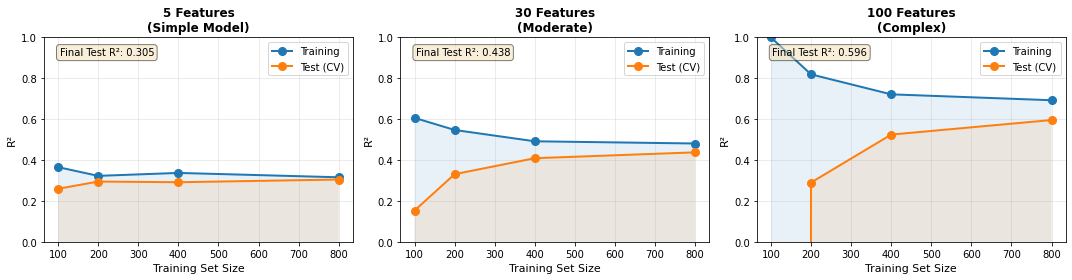

In [ ]:
# Helper function to plot multiple learning curves
def plot_learning_curves(models, X_sets, y, train_sizes, labels, cv=5):
    """Plot learning curves for multiple models/feature sets."""
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))
    
    if len(models) == 1:
        axes = [axes]
    
    for idx, (model, X, label) in enumerate(zip(models, X_sets, labels)):
        # Compute learning curve
        sizes, train_scores, test_scores = learning_curve(
            model, X, y,
            train_sizes=train_sizes,
            cv=cv,
            scoring='r2',
            shuffle=True
        )
        
        # Calculate means
        train_mean = train_scores.mean(axis=1)
        test_mean = test_scores.mean(axis=1)
        
        # Plot
        ax = axes[idx]
        ax.plot(sizes, train_mean, 'o-', label='Training', linewidth=2, markersize=8)
        ax.plot(sizes, test_mean, 'o-', label='Test (CV)', linewidth=2, markersize=8)
        ax.fill_between(sizes, 0, train_mean, alpha=0.1)
        ax.fill_between(sizes, 0, test_mean, alpha=0.1)
        
        ax.set_xlabel('Training Set Size', fontsize=11)
        ax.set_ylabel('R²', fontsize=11)
        ax.set_title(label, fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)
        
        # Add final test score annotation
        final_score = test_mean[-1]
        ax.text(0.05, 0.95, f'Final Test R²: {final_score:.3f}',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
# Compare models with different numbers of features
X_5 = X_all.sample(5, axis=1, random_state=99)
X_30 = X_all.sample(30, axis=1, random_state=99)
X_100 = X_all.sample(100, axis=1, random_state=99)

# Define models and feature sets
models = [LinearRegression()] * 3
X_sets = [X_5, X_30, X_100]
labels = ['5 Features\n(Simple Model)', '30 Features\n(Moderate)', '100 Features\n(Complex)']
train_sizes = [100, 200, 400, 800]

print("Comparing model complexity across different training sizes...")
print("This may take a minute...\n")

plot_learning_curves(models, X_sets, y, train_sizes, labels, cv=5)

### Model Complexity and Sample Size

How does model complexity interact with dataset size? Let's compare models using different numbers of features.

## Summary

**Critical Concepts:**

1. **Always evaluate on independent test data** to detect overfitting
2. **K-fold cross-validation** provides robust performance estimates
3. **Learning curves** diagnose overfitting and data needs
4. **Balance model complexity with dataset size**

**Rules of Thumb:**
- Large train-test gap → overfitting (reduce complexity or add data)
- Poor performance on both → underfitting (increase complexity)
- Test performance improves with more data → collect more samples

**Next**: Learn regularization techniques to prevent overfitting!